本部分代码同DFCNN.ipynb，仅仅是读取label时读取拼音而非中文，故不多加注释。

In [1]:
#相关包
from scipy.io import wavfile #音频数据读取
from scipy.fftpack import fft #音频数据处理-傅里叶变换
import os
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle #数据生成器中的打乱

import keras
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D
from keras.layers import Reshape, Dense, Lambda
from keras.optimizers import Adam
from keras import backend as K
from keras.models import Model
from keras.utils import multi_gpu_model

Using TensorFlow backend.


In [2]:
# 本部分自定义函数：
# 从文件夹中读取音频数据、标签的文件名，存入数组
def source_get(source_file):
    train_file = source_file + '/train'
    label_lst = []
    wav_lst = []
    for root, dirs, files in os.walk(train_file):
        for file in files:
            if file.endswith('.wav') or file.endswith('.WAV'):
                wav_file = os.sep.join([root, file])
                label_file = source_file + '/data/' + file +'.trn'
                wav_lst.append(wav_file)
                label_lst.append(label_file)

    return label_lst, wav_lst

# 输入路径，读取音频文件对应的label
def read_label(label_file):
    with open(label_file, 'r', encoding='utf8') as f:
        data = f.readlines()
        return data[1]

# 输入路径数组，读取所有label
def gen_label_data(label_lst):
    label_data = []
    for label_file in label_lst:
        pny = read_label(label_file)
        label_data.append(pny.strip('\n'))
    return label_data

In [3]:
# 本部分自定义函数：
# 提取本数据集label中所有汉字（不重复）形成词汇表vacab
def mk_vocab(label_data):
    vocab = []
    for line in label_data:
        line = line.split(' ')
        for pny in line:
            if pny not in vocab:
                vocab.append(pny)
    vocab.append('_')
    return vocab

# 将vocab中的汉字转数字id
def word2id(line, vocab):
    return [vocab.index(pny) for pny in line.split(' ')]

In [4]:
#本部分自定义函数（同演示部分的函数）
def compute_fbank(file):
    x = np.linspace(0, 400 - 1, 400, dtype=np.int64)
    w = 0.54 - 0.46 * np.cos(2 * np.pi * (x) / (400 - 1))  # 汉明窗
    
    sample_rate,wavdata = wavfile.read(file)  ##单声道是一维的，立体音是二维
    
    # wav波形 加时间窗以及时移10ms
    time_window = 25  # 单位ms
    window_length = sample_rate / 1000 * time_window  # 计算窗长度的公式，目前全部为400固定值
    
    wav_arr = np.array(wavdata)
    wav_length = len(wavdata)
    range0_end = int(len(wavdata) / sample_rate * 1000 - time_window) // 10  # 计算循环终止的位置，也就是最终生成的窗数
    #print(range0_end)
    
    data_input = np.zeros((range0_end, 200), dtype=np.float64)  # 用于存放最终的频率特征数据
    data_line = np.zeros((1, 400), dtype=np.float64)
    for i in range(0, range0_end):
        p_start = i * 160
        p_end = p_start + 400
        data_line = wav_arr[p_start:p_end]
        data_line = data_line * w
        data_line = np.abs(fft(data_line))
        data_input[i] = data_line[0:200]
    data_input = np.log(data_input + 1)
    return data_input

In [5]:
# 本部分自定义函数：

# 时频图的补零处理：
def wav_padding(wav_data_lst):
    
    wav_lens = [len(data) for data in wav_data_lst] # 时频图长度
    wav_max_len = max(wav_lens) # 时频图长度最大值
    
    #新的时频图矩阵（四维：前两维为图片个数、音频长度，后两维代表了每帧的时频图）
    new_wav_data_lst = np.zeros((len(wav_data_lst), wav_max_len, 200, 1))
    for i in range(len(wav_data_lst)):
        new_wav_data_lst[i, :wav_data_lst[i].shape[0], :, 0] = wav_data_lst[i]
    
    #后续输入ctc的音频长度（由于ctc处理之前经过神经网络处理，长度缩短为8倍）
    wav_lens = np.array([leng // 8 for leng in wav_lens])
    
    return new_wav_data_lst, wav_lens

# label的补零处理：
def label_padding(label_data_lst):
    
    label_lens = np.array([len(label) for label in label_data_lst])
    max_label_len = max(label_lens)
    
    new_label_data_lst = np.zeros((len(label_data_lst), max_label_len))
    for i in range(len(label_data_lst)):
        new_label_data_lst[i][:len(label_data_lst[i])] = label_data_lst[i]
        
    return new_label_data_lst, label_lens

# 用于训练格式的数据生成器
def data_generator(batch_size, shuffle_list, wav_lst, label_data, vocab):
    
    for i in range(len(wav_lst) // batch_size):
        wav_data_lst = []
        label_data_lst = []
        
        begin = i * batch_size
        end = begin + batch_size
        sub_list = shuffle_list[begin:end]
        
        for index in sub_list:
            #转为频谱图
            fbank = compute_fbank(wav_lst[index])
            pad_fbank = np.zeros((fbank.shape[0] // 8 * 8 + 8, fbank.shape[1]))
            pad_fbank[:fbank.shape[0], :] = fbank
            #读取label
            label = word2id(label_data[index], vocab)
            
            wav_data_lst.append(pad_fbank)
            label_data_lst.append(label)
            
        pad_wav_data, input_length = wav_padding(wav_data_lst)
        pad_label_data, label_length = label_padding(label_data_lst)
        
        inputs = {'the_inputs': pad_wav_data,
                  'the_labels': pad_label_data,
                  'input_length': input_length,
                  'label_length': label_length,
                  }
        outputs = {'ctc': np.zeros(pad_wav_data.shape[0], )}
        
        yield inputs, outputs

In [7]:
def dense(units, activation="relu"):
    return Dense(units, activation='relu', use_bias=True,
                 kernel_initializer='he_normal')


#构造DFCNN中的卷积池化层函数（两个卷积+BN）
def cnn_cell(size, x, pool=True):
    x = Conv2D(size, (3, 3), use_bias=True, activation='relu',padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(size, (3, 3), use_bias=True, activation='relu',padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=-1)(x)
    if pool:
        x = MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
    return x

#使用CTC损失函数（keras内置）
def ctc_lambda(args):
    labels, y_pred, input_length, label_length = args
    y_pred = y_pred[:, :, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

#DFCNN模型
class Amodel():
    #给出必要的参数并对模型初始化
    def __init__(self, vocab_size):
        super(Amodel, self).__init__()
        self.vocab_size = vocab_size
        self._model_init()
        self._ctc_init()
        self.opt_init()

    #DFCNN构建（四个卷积池化层、两个全连接层）
    def _model_init(self):
        self.inputs = Input(name='the_inputs', shape=(None, 200, 1))
        self.h1 = cnn_cell(32, self.inputs)
        self.h2 = cnn_cell(64, self.h1)
        self.h3 = cnn_cell(128, self.h2)
        self.h4 = cnn_cell(128, self.h3, pool=False)
        self.h6 = Reshape((-1, 3200))(self.h4)
        self.h7 = Dense(256, activation='relu', use_bias=True, kernel_initializer='he_normal')(self.h6)
        self.outputs = Dense(self.vocab_size, activation='softmax', use_bias=True, kernel_initializer='he_normal')(self.h7)
        self.model = Model(inputs=self.inputs, outputs=self.outputs)
    
    #CTC构建（输入输出为前文padding函数的返回值）
    def _ctc_init(self):
        self.labels = Input(name='the_labels', shape=[None], dtype='float32')
        self.input_length = Input(name='input_length', shape=[1], dtype='int64')
        self.label_length = Input(name='label_length', shape=[1], dtype='int64')
        self.loss_out = Lambda(ctc_lambda, output_shape=(1,), name='ctc') \
            ([self.labels, self.outputs, self.input_length, self.label_length])
        self.ctc_model = Model(inputs=[self.labels, self.inputs,
                                       self.input_length, self.label_length], outputs=self.loss_out)
        
    #优化函数构建（使用adam优化器）
    def opt_init(self):
        opt = Adam(lr=0.0008, beta_1=0.9, beta_2=0.999, decay=0.01, epsilon=10e-8)
        self.ctc_model.compile(loss={'ctc': lambda y_true, output: output}, optimizer=opt)

In [8]:
total_nums = 2000
batch_size = 8 # batch_size太大会出现内存溢出
batch_num = total_nums // batch_size
epochs = 50

source_file = '/mnt/thchs30'
label_lst, wav_lst = source_get(source_file)
label_data = gen_label_data(label_lst[:total_nums])
vocab = mk_vocab(label_data)
vocab_size = len(vocab)

print(vocab_size)

shuffle_list = [i for i in range(total_nums)]

1168


In [9]:
am = Amodel(vocab_size)
am.ctc_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_inputs (InputLayer)         (None, None, 200, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, 200, 32 320         the_inputs[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 200, 32 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, 200, 32 9248        batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [10]:
loss = []
for k in range(epochs):
    print('this is the', k + 1, 'th epochs trainning !!!')
    batch = data_generator(batch_size, shuffle_list, wav_lst, label_data, vocab)
    result = am.ctc_model.fit_generator(batch, steps_per_epoch=batch_num, epochs=1)
    loss.append(result.history['loss'])

this is the 1 th epochs trainning !!!
Epoch 1/1
250/250 [==============================] - 433s 2s/step - loss: 222.6170
this is the 2 th epochs trainning !!!
Epoch 1/1
250/250 [==============================] - 243s 972ms/step - loss: 204.3487
this is the 3 th epochs trainning !!!
Epoch 1/1
250/250 [==============================] - 243s 972ms/step - loss: 183.9723
this is the 4 th epochs trainning !!!
Epoch 1/1
250/250 [==============================] - 243s 971ms/step - loss: 153.4364
this is the 5 th epochs trainning !!!
Epoch 1/1
250/250 [==============================] - 242s 967ms/step - loss: 129.2037
this is the 6 th epochs trainning !!!
Epoch 1/1
250/250 [==============================] - 242s 970ms/step - loss: 112.3276
this is the 7 th epochs trainning !!!
Epoch 1/1
250/250 [==============================] - 243s 972ms/step - loss: 100.4432
this is the 8 th epochs trainning !!!
Epoch 1/1
250/250 [==============================] - 243s 972ms/step - loss: 91.6195
this is the 

Text(0, 0.5, 'ctc-loss')

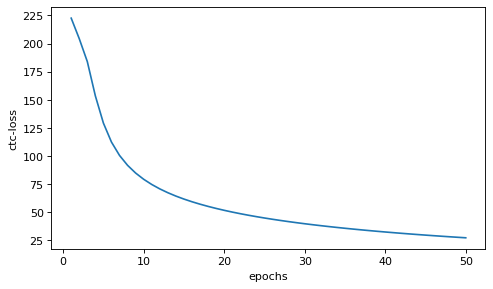

In [3]:
#loss的可视化
x = range(1,51)
plt.figure(figsize=(7,4),dpi=80)
plt.plot(x, loss)
plt.xlabel('epochs') 
plt.ylabel('ctc-loss')

In [11]:
#对模型输出结果进行解码，转为拼音
def decode_ctc(num_result, num2word):
    result = num_result[:, :, :]
    in_len = np.zeros((1), dtype=np.int32)
    in_len[0] = result.shape[1]
    r = K.ctc_decode(result, in_len, greedy=True, beam_width=10, top_paths=1)
    r1 = K.get_value(r[0][0])
    r1 = r1[0]
    text = []
    for i in r1:
        text.append(num2word[i])
    return r1, text

batch = data_generator(1, shuffle_list, wav_lst, label_data, vocab)
for i in range(10):
    # 载入训练好的模型，并进行识别
    inputs, outputs = next(batch)
    x = inputs['the_inputs']
    y = inputs['the_labels'][0]
    result = am.model.predict(x, steps=1)
    # 将数字结果转化为文本结果
    result, text = decode_ctc(result, vocab)
    print('数字结果： ', result)
    print('文本结果：', text)
    print('原文结果：', [vocab[int(i)] for i in y])

数字结果：  [  0 482   2   3   4   5   6   3 572   8   9  10  11  12  34  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28]
文本结果： ['zhu4', 'mian4', 'yan3', 'yuan2', 'you3', 'cheng2', 'fang1', 'yuan2', 'mu4', 'xuan4', 'fu3', 'yuan3', 'zheng1', 'zhang1', 'quan2', 'chen2', 'jun4', 'hua2', 'zi1', 'sha1', 'li4', 'ou1', 'yang2', 'bin1', 'lin2', 'wen2', 'zeng1', 'zhou1', 'wei2', 'deng3']
原文结果： ['zhu4', 'ming2', 'yan3', 'yuan2', 'you3', 'cheng2', 'fang1', 'yuan2', 'mou2', 'xuan4', 'fu3', 'yuan3', 'zheng1', 'zhang1', 'qiang2', 'chen2', 'jun4', 'hua2', 'zi1', 'sha1', 'li4', 'ou1', 'yang2', 'bin1', 'lin2', 'wen2', 'zeng1', 'zhou1', 'wei2', 'deng3']
数字结果：  [ 29  30  31  72 277  34  35  36 142  38  39 192  40  41 419 915  44   5
  46  45  27  47 248  48 368  49  28]
文本结果： ['ke3', 'fa1', 'zhan3', 'sheng1', 'nian2', 'quan2', 'se4', 'bei4', 'kan1', 'yin4', 'hua1', 'bi4', 'dan1', 'gou1', 'gan1', 'sun3', 'rong2', 'cheng2', 'zhao4', 'chuang2', 'wei2', 'zhen3', 'ta1', 'pei4', 'fen1', 'jian4', 'deng3